In [18]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

ModuleNotFoundError: No module named 'cvxopt'

In [3]:
# Read data into pandas
japan = pd.read_excel("./data/Price History_EWJ_Japan_Equity.xlsx")
t_bills_7_10 = pd.read_excel("./data/Price History_7-10_US_TBills.xlsx")
t_bills_20 = pd.read_excel("./data/Price History_20+_US_TBills.xlsx")
apac_x_japan = pd.read_excel("./data/Price History_EPP_APACxJapan_Equity.xlsx")
europe = pd.read_excel("./data/Price History_IEV_Europe_Equity.xlsx")
latam = pd.read_excel("./data/Price History_ILF_LatAm_Equity.xlsx")
us = pd.read_excel("./data/Price History_IVV_US_Equity.xlsx")
gold = pd.read_excel("./data/Price History_IAU_Gold_Trust.xlsx")

In [4]:
def preprocess_and_rename(df, name):
    df['Exchange Date'] = pd.to_datetime(df['Exchange Date'])
    df.set_index('Exchange Date', inplace=True)
    df.rename(columns={'%Chg':f'Return {name}'}, inplace=True)
    return df[[f'Return {name}']]

# Preprocess all datasets and rename columns
japan = preprocess_and_rename(japan, 'Japan')
t_bills_7_10 = preprocess_and_rename(t_bills_7_10, 'T-Bills_7_10')
t_bills_20 = preprocess_and_rename(t_bills_20, 'T-Bills_20')
apac_x_japan = preprocess_and_rename(apac_x_japan, 'APACxJapan')
europe = preprocess_and_rename(europe, 'Europe')
latam = preprocess_and_rename(latam, 'LatAm')
us = preprocess_and_rename(us, 'US')
gold = preprocess_and_rename(gold, 'Gold')

In [5]:
us

,Return US
Exchange Date,
2024-12-13,-0.000181
2024-12-12,-0.005306
2024-12-11,0.007707
2024-12-10,-0.002896
2024-12-09,-0.005157
...,...
2005-01-07,-0.001852
2005-01-06,0.004058
2005-01-05,-0.006050


In [6]:
# Merge all datasets on 'Exchange Date'
returns = japan.join([t_bills_7_10, t_bills_20, apac_x_japan, europe, latam, us, gold], how='inner')

# Rename the columns for clarity
returns.columns = ['Japan', 'T-Bills_7_10', 'T-Bills_20', 
                'APACxJapan','Europe','LatAm', 'US', 'Gold']
returns = returns.dropna()
returns = returns.sort_values(by='Exchange Date', ascending=True)

In [7]:
returns

,Japan,T-Bills_7_10,T-Bills_20,APACxJapan,Europe,LatAm,US,Gold
Exchange Date,,,,,,,,
2005-01-31,0.000000,0.000350,0.002843,0.002793,0.004750,0.017648,0.008956,-0.009838
2005-02-01,0.005666,-0.003734,-0.005343,0.008802,0.010265,0.013544,0.006425,-0.003549
2005-02-02,0.003756,0.000117,0.002302,0.000884,-0.000668,0.009117,0.003192,0.002612
2005-02-03,-0.014967,-0.001757,-0.000875,-0.008056,-0.002676,0.010767,-0.001758,-0.012077
2005-02-04,0.004748,0.005280,0.014231,0.007231,0.003622,0.017877,0.009646,-0.005273
...,...,...,...,...,...,...,...,...
2024-12-09,-0.008723,-0.003464,-0.009217,0.018423,-0.001273,0.012993,-0.005157,0.009863
2024-12-10,-0.005393,-0.001791,-0.004705,-0.016197,-0.008379,0.000855,-0.002896,0.013155
2024-12-11,0.014127,-0.002955,-0.009454,0.000000,0.004041,0.015805,0.007707,0.009247


[-0.6481988  -1.15058385  2.06805409  1.03068393  0.23502215  0.07637549
 -0.16187718 -0.44947582]
[ 0.56707364  1.25979823 -1.18350881 -0.38653527  0.01796312 -0.19780342
  0.57645665  0.34655587]
[-0.9112025   0.62478722  2.4870475  -3.7683224   5.64771045  0.78411909
 -2.75597344 -1.10816591]
[-0.23541241 -0.05861461  0.33013356 -0.53416509  0.48172832 -0.13935699
  0.65081066  0.50487655]
[-0.00321375 -0.09675226  0.36658474 -0.66325154  0.29326337 -0.09624563
  0.61249763  0.58711745]
[-0.18771715  0.26686985 -0.06312617 -0.43906264  0.03816646 -0.12488912
  0.86855489  0.64120388]
[ 2.18568873  6.26474572 -5.96238057 -0.29666971 -6.07865565  0.59705961
  2.02564685  2.26456502]
[ 0.01392832  0.14435895  0.0960669  -0.38002661  0.14951059 -0.13884129
  0.65422633  0.46077681]
[ 0.01200321  0.20793706  0.05563219 -0.32769355  0.14319913 -0.13560498
  0.61790101  0.42662593]
[-0.16675439  2.05786988 -1.16064276 -0.0447665   0.39182959  0.00702623
 -0.13089468  0.04633263]
[-0.121060

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/frame.py:10866: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


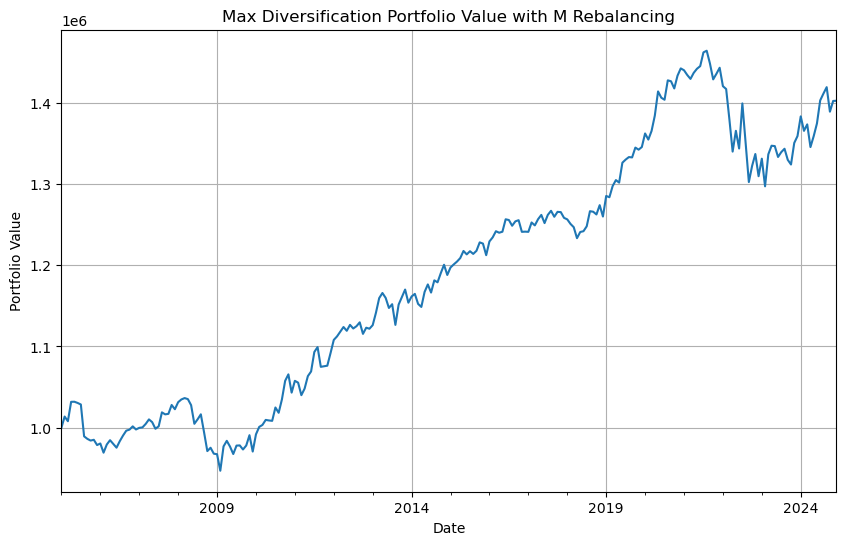

In [17]:
def max_diversification_portfolio(data, rebalance_frequency='M', initial_investment=1_000_000):
    """
    Function to implement a Max Diversification Portfolio with dynamic rebalancing frequency.
    
    Args:
        data (pd.DataFrame): DataFrame containing the asset returns.
        rebalance_frequency (str): The rebalancing frequency. Defaults to 'M' (monthly). 
                                   Other options: 'Q' (quarterly), 'A' (annually).
        initial_investment (float): The initial investment amount.
    
    Returns:
        pd.DataFrame: Portfolio value over time.
    """
    
    # Resample returns based on the rebalancing frequency (e.g., monthly, quarterly)
    data_resampled = data.resample(rebalance_frequency).apply(lambda x: (1 + x).prod() - 1)
    
    # Create an empty list to store portfolio values
    portfolio_values = []
    
    # Initialize portfolio value
    portfolio_value = initial_investment
    
    # Loop through each date in the resampled returns data
    for i in range(len(data_resampled)):
        if i == 0:  # On the first date, initialize weights
            cov_matrix = data_resampled.iloc[:i+1].cov()
            cov_matrix_inv = np.linalg.inv(cov_matrix)
            ones = np.ones(cov_matrix.shape[0])
            weights = cov_matrix_inv.dot(ones) / ones.dot(cov_matrix_inv).dot(ones)
            portfolio_value = initial_investment  # Start with the initial investment
        else:
            # Calculate covariance matrix for the current period
            cov_matrix = data_resampled.iloc[:i+1].cov()
            cov_matrix_inv = np.linalg.inv(cov_matrix)
            ones = np.ones(cov_matrix.shape[0])
            
            # Recalculate the portfolio weights based on the new covariance matrix
            weights = cov_matrix_inv.dot(ones) / ones.dot(cov_matrix_inv).dot(ones)
            print(weights)
            # Update portfolio value based on the new weights and returns for the current period
            monthly_return = data_resampled.iloc[i].dot(weights)  # Dot product of returns and weights
            portfolio_value *= (1 + monthly_return)  # Update portfolio value
            
        # Append the portfolio value to the list
        portfolio_values.append(portfolio_value)
    
    # Convert the list to a DataFrame for easier visualization
    portfolio_values_df = pd.DataFrame(portfolio_values, columns=['Portfolio Value'], index=data_resampled.index)
    
    return portfolio_values_df


# Example usage

# Load your data (daily returns for each asset, as you already have)
# For example:
# japan = pd.read_excel("your_file.xlsx")

# Assuming you've calculated the daily returns and have them in a DataFrame called `returns`
# Here's how you'd pass that data into the function

# Example data (replace this with your actual returns data)
returns = returns

# Specify rebalancing frequency, e.g., 'M' for monthly, 'Q' for quarterly, etc.
rebalance_frequency = 'M'  # Monthly rebalancing

# Get the portfolio value over time
portfolio_value = max_diversification_portfolio(returns, rebalance_frequency)

# Plot the portfolio value over time
portfolio_value['Portfolio Value'].plot(figsize=(10, 6))
plt.title(f'Max Diversification Portfolio Value with {rebalance_frequency} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()

In [15]:
print(f"Average annualized monthly volatility: {rolling_annual_volatility.mean()}")
total_return = (portfolio_value.iloc[-1]-portfolio_value.iloc[0])/portfolio_value.iloc[0]
print(f"Total return: {total_return*100}%")
monthly_returns = portfolio_returns
avg_monthly_return = monthly_returns.mean()
print(f"Average monthly return: {avg_monthly_return}")
print(f"Average yearly return: {((1+avg_monthly_return)**12)-1}")
print(f"Sharpe Ratio: {(((1+avg_monthly_return)**12)-1)/rolling_annual_volatility.mean()}")

NameError: name 'rolling_annual_volatility' is not defined

In [19]:
# Calculate the monthly VaR for each month using the Historical Simulation method
VaR_99 = portfolio_returns.quantile(1 - 0.99)

# Print the Value at Risk
print(f"Monthly 99% Value at Risk (VaR) is: {VaR_99:.4f}")

Monthly 99% Value at Risk (VaR) is: -0.0847
